Attention Layer with Contrastive Learning

In [1]:
#https://github.com/Stonesjtu/Pytorch-NCE/blob/master/nce/nce_loss.py

In [2]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import pandas

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [3]:
from data.utils import SimpleDataset

from utils.metrics import NLL_reg, point_loss, get_CI_raw
from utils.trainer_helpers import batch_t_categorize, wt_avg



## Cox-gompertz linear setting

Load framingham dataset

In [4]:
from data.simulation import simulation_cox_weibull_all, single_subj_true_dist_cox_gompertz

file_path = '/data/zidi/framingham/'
result_path_root = '/data/zidi/ACSurv/results/toy_bin/e40'
# file_path = '/Users/ZidiXiu/Dropbox/Research/framingham/data/'
# result_path_root = "/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results"+'/toy'

cut_bound = 6
df= simulation_cox_weibull_all(n=20000, censor_bound=68)

# change to non-ohe 
cat0_level = df['ohe'][0]
cat1_level = df['ohe'][1]

# cat0 = 0*df['x'][:,2] + 1*df['x'][:,3]+ 2*df['x'][:,4]+ 3*df['x'][:,5]
cat0 = np.sum(np.array([level*df['x'][:, 2+level] for level in range(cat0_level)]),0).reshape(-1,1)
cat1 = np.sum(np.array([level*df['x'][:, 2+cat0_level+level] for level in range(cat1_level)]),0).reshape(-1,1)


df['x'] = np.concatenate((df['x'][:,df['cts_idx']], cat0, cat1), axis=1)
nsamples, ncov= df['x'].shape

cov_list = np.array(['AGE','RANDON', 'cat0','cat1'])
cts_idx = df['cts_idx']
cts_var = cov_list[cts_idx]
cat_idx = np.setdiff1d(np.arange(ncov), cts_idx)
cat_var = cov_list[cat_idx]


true_beta = df['coef']
ncov, np.mean(df['e'])

(4, 0.41815)

<AxesSubplot:ylabel='Density'>

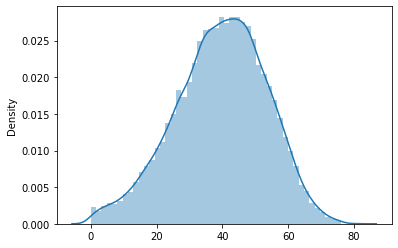

In [5]:
sns.distplot(df['T'])

In [6]:
from data.utils import *
nsamples, ncov= df['x'].shape
np.random.seed(123)
all_idx = np.arange(nsamples)
all_idx = np.random.permutation(all_idx)
train_idx = all_idx[:int(2*nsamples/3)]
valid_idx = all_idx[int(2*nsamples/3):]

train = formatted_data(df['x'], df['t'], df['e'], train_idx)
valid = formatted_data(df['x'], df['t'], df['e'], valid_idx)

train_size = train['x'].shape[0]
val_size = valid['x'].shape[0]

del df

observed fold:0.4176854421360534
observed fold:0.41907904604769763


In [7]:
nbin=100
m = 10
train_time = train['t']
percentile = True


if percentile:
    '''based on each covariate percentile'''
    t_landmarks = torch.tensor(np.percentile(train_time, np.linspace(0,100,m))).contiguous()
    tt = np.percentile(train_time,np.linspace(0.,100.,nbin, endpoint=True))
else:
    '''based on the each covariate range'''
    t_landmarks = torch.tensor(np.linspace(np.min(train_time),np.max(train_time),m, endpoint=True)).contiguous()
    tt = np.linspace(np.min(train_time),np.max(train_time),nbin, endpoint=True)


            
# based on whether we have censoring after the largest observed t
loss_of_info = np.mean(train['t']>np.max(train['t'][train['e']==1]))

# need to convert t to different size of bins
if loss_of_info > 0.0001:
    nbin = nbin + 1
    # add the largest observed censoring time inside
    tt = np.append(tt,np.max(train['t']))
#     event_tt_prob = risk_t_bin_prob(train['t'], train['e'], tt)
t_max = np.max(train['t'][train['e']==1])
t_all_max = np.max(train['t'])
tt, t_all_max, t_max

(array([5.56835773e-03, 6.30909232e-01, 1.20878117e+00, 1.89860159e+00,
        2.48163218e+00, 3.20253833e+00, 3.79200266e+00, 4.35664143e+00,
        4.95472852e+00, 5.62608850e+00, 6.19138416e+00, 6.66860660e+00,
        7.29327437e+00, 7.90829941e+00, 8.48977402e+00, 9.08618901e+00,
        9.68788148e+00, 1.02882362e+01, 1.08031260e+01, 1.13277381e+01,
        1.18070378e+01, 1.23565697e+01, 1.28485766e+01, 1.34008280e+01,
        1.39448214e+01, 1.45029414e+01, 1.49932712e+01, 1.55453049e+01,
        1.61385214e+01, 1.66659473e+01, 1.71902247e+01, 1.77045729e+01,
        1.82603937e+01, 1.87676739e+01, 1.92906125e+01, 1.98633438e+01,
        2.03338726e+01, 2.08581072e+01, 2.12864561e+01, 2.18129434e+01,
        2.22682393e+01, 2.27907670e+01, 2.32455488e+01, 2.36962493e+01,
        2.41828335e+01, 2.46780311e+01, 2.51517542e+01, 2.56334022e+01,
        2.61204538e+01, 2.65528660e+01, 2.70265423e+01, 2.74684735e+01,
        2.79122101e+01, 2.83698329e+01, 2.87881066e+01, 2.923325

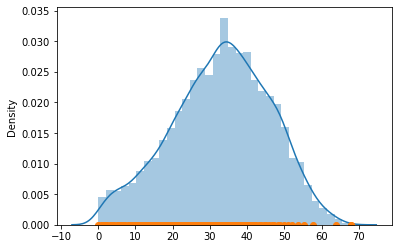

In [8]:
sns.distplot(train['t'][train['e']==1])
plt.plot(tt, np.zeros(len(tt)),'o')

In [9]:
t_landmarks

tensor([5.5684e-03, 6.6686e+00, 1.2849e+01, 1.8768e+01, 2.4183e+01, 2.9233e+01,
        3.4282e+01, 3.9607e+01, 4.6583e+01, 6.8000e+01], dtype=torch.float64)

### Embedding the covariates into $\mathbb{R}^m$
- for each continuous variable, first find $m$ landmarkers, then interpolate values in between
- for each categorical variable, find the matched embedding vector with $m$ dimensions

Define landmarkers for each continuous variable### Embedding the covariates into $\mathbb{R}^m$

In [10]:
# import torch
# from torch import nn, optim
# import numpy as np

# # Type hinting
# from typing import Union, List, Optional, Any, Tuple
# from torch import FloatTensor, LongTensor


# class SimpleMLP(nn.Module):
#     def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
#         super(SimpleMLP, self).__init__()
#         net = []
#         hs = [input_size] + h_dim + [output_size]
#         for h0, h1 in zip(hs, hs[1:]):
#             net.extend([
#                 nn.Linear(h0, h1),
#                 nn.ReLU(),
#             ])
#         net.pop()  # pop the last ReLU for the output layer
#         self.net = nn.Sequential(*net)
#         self.out = torch.nn.Sigmoid()
        
#     def forward(self, x):
#         z = self.net(x)
#         return self.out(z)
    
    
# class FDV_Contrastive(nn.Module):
#     def __init__(self, m, input_size=None, output_size=None, h_dim=[512,512], t_landmarks = None, train_time = None, percentile=False, tau = 1.0):
#         super(FDV_Contrastive, self).__init__()
#         # learnable temperature
#         self.log_tau = torch.nn.Parameter(torch.Tensor([np.log(tau)]))
#         self.criterion = torch.nn.CrossEntropyLoss(reduction='none')
#         self.m = m
#         self.time_landmark, self.time_emb_landmark = self.time_emb_init(t_landmarks, train_time, percentile)
        
#         if input_size == None:
#             self.enc = nn.Identity()
#         else:
#             net = []
#             hs = [input_size] + h_dim + [output_size]
#             for h0, h1 in zip(hs, hs[1:]):
#                 net.extend([
#                     nn.Linear(h0, h1),
#                     nn.ReLU(),
#                 ])
#             net.pop()  # pop the last ReLU for the output layer
#             self.enc = nn.Sequential(*net)
            
        
#     def forward(self, z, t, e):

#         tau = torch.sqrt(torch.exp(self.log_tau))    
#         device = z.device
        
#         batch_dim = z.size(0)
#         # by dimension encoding
#         # [batch_size, ncov*n_emb]
#         hz = (self.norm(self.enc(z)))/tau
#         # [batch_size, n_emb]
#         hy = (self.linear_interpolation_time(t, e))/tau
#         hy_new = torch.repeat_interleave(clf.linear_interpolation_time(y, e)/tau, torch.tensor(batch_dim*[4]).to(device), dim=0).view(-1,hz.size()[-1])
#         del z, t, e, hy
        
#         # [batch_size, batch_size]
#         similarity_matrix = hz @ hy_new.t()
       
#         del hz, hy_new
#         pos_mask = torch.eye(batch_dim,dtype=torch.bool)
        
#         g = similarity_matrix[pos_mask].view(batch_dim,-1)
#         g0 = similarity_matrix[~pos_mask].view(batch_dim,-1)
            
#         del pos_mask
#         logits = g0 - g
            
#         slogits = torch.logsumexp(logits,1).view(-1,1)
            
#         labels = torch.tensor(range(batch_dim),dtype=torch.int64).to(device)
#         dummy_ce = self.criterion(similarity_matrix,labels) - torch.log(torch.Tensor([batch_dim]).to(device))
        
#         del similarity_matrix
#         dummy_ce = dummy_ce.view(-1,1)
            
#         output = dummy_ce.detach()+torch.exp(slogits-slogits.detach())-1
        
#         del dummy_ce
#         output = torch.clamp(output,-5,15)
        
#         return output.mean()
    
    
#     def linear_interpolation_time(self, batch_t, batch_e):
#         '''
#         Time embedding based on event type
#         '''
#         # written for torch
#         # returns index
#         # a[i-1] < v <= a[i]
#         indx = torch.searchsorted(self.time_landmark.to(batch_t.device), batch_t)
#         # combine the first two indices, and the last two indices
#         # to include the unobserved minimum and maximum value
#         # combines [0,1], and [m-1, m]
#         indx = torch.where(indx==0, 1, indx)
#         indx = torch.where(indx==self.m, self.m-1, indx)

        
# #         print(batch_t.size(), batch_e.size(), len(indx))
        
#         # for event
#         coef = (self.time_emb_landmark[indx] - self.time_emb_landmark[indx-1])/(self.time_landmark[indx].to(batch_t.device) - self.time_landmark[indx-1].to(batch_t.device)).view(len(indx),1)
# #         print(coef.size())
#         out = self.time_emb_landmark[indx-1] + coef*(batch_t-self.time_landmark[indx-1].to(batch_t.device)).view(len(indx),1)    # linear interpolation

#         # for censoring
#         censor_mask = torch.vstack([(torch.cat((torch.zeros(idx), torch.ones(m-idx))).view(1, m))/(m-idx) for idx in indx.to('cpu')])
#         out_censor = torch.matmul(censor_mask.to(batch_t.device), self.time_emb_landmark.T)
        
#         del censor_mask, coef

#         return (out*batch_e.view(len(out),1) + out_censor*(1-batch_e).view(len(out),1)).float()
    
#     def time_emb_init(self, t_landmarks, train_time, percentile = True):
#         '''
#         embedding of time-to-event distribution 

#         '''

#         if type(t_landmarks) == type(None):
#             if percentile:
#                 '''based on each covariate percentile'''
#                 t_landmarks = torch.tensor(np.percentile(train_time, np.linspace(0,100,self.m))).contiguous()
#             else:
#                 '''based on the each covariate range'''
#                 t_landmarks = torch.tensor(np.linspace(np.min(train_time),np.max(train_time),self.m, endpoint=True)).contiguous()

#         # save the initialized landmarks as a torch parameter dictionary

#         t_emb_landmarks = torch.eye(self.m)

#         return t_landmarks, torch.nn.Parameter(t_emb_landmarks)    
    
#     def norm(self,z):
#         return torch.nn.functional.normalize(z,dim=-1)

In [11]:
ncov = train['x'].shape[1]
covList = np.arange(ncov)

trainData = SimpleDataset(train['x'], train['t'], train['e'])
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
# pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(valid['x'], valid['t'], valid['e'])
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)


In [12]:
result_path_root

'/data/zidi/ACSurv/results/toy_bin/e40'

In [13]:
from utils.trainer_helpers import batch_t_categorize, wt_avg, attention_mask
from model.embedding import Embedding
from model.attention import Attention, SelfAttention
from model.ContrastiveLearning import FDV_CL
from model.SimpleNN import *


m=8
zdim = m
epochs = 1000
device = 'cuda'
model_name = 'AttCtra'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(1)

# point estimation loss function and weight
loss_type='MSE'
lambda_ = 0
ctr_learning = True
ctr_wt = 1
# bined time
tt = torch.tensor(tt).to(device)

result_path = result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

'''covariate embedding'''
embedding = Embedding(ncov, cts_var, cts_idx, cat_var, cat_idx, dataset=train, m=m)

'''attention network'''
# attention = LinearAtt(ncov=ncov, dropout=0.1)
# attention = Attention(dropout=0.1)
attention = SelfAttention(dropout=0.1)

'''contrastive learning'''
# input is pair of latent Z
clf = FDV_CL(m = m, t_landmarks = t_landmarks, h_dim = [0], ncov=ncov)


'''decoding the embedded vectors'''
# decoder = DecMLP(input_size = zdim*ncov, output_size = 1, h_dim=[512, 512])
decoder = DecMLP_bin(input_size = zdim*ncov, output_size = nbin, h_dim=[512,512])

# emb = torch.nn.DataParallel(embedding, device_ids=[0, 1])
# dec = torch.nn.DataParallel(decoder, device_ids=[0, 1])
# att = torch.nn.DataParallel(attention, device_ids=[0, 1])
# ctra = torch.nn.DataParallel(clf, device_ids=[0, 1])

# enc = clf.enc
embedding.to(device)
clf.to(device)
# attention.to(device)
decoder.to(device)

# define optimizer
opt_emb = optim.Adam(embedding.parameters(), lr=1e-3)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)
opt_clf = optim.Adam(clf.parameters(), lr=1e-4)

# opt_att = optim.Adam(attention.parameters(), lr=1e-4)

emb_path = result_path+model_name+'_emb_'+str(ctr_wt)+'.pt'
dec_path = result_path+model_name+'_dec_'+str(ctr_wt)+'.pt'

clf_path = result_path+model_name+'_clf_'+str(ctr_wt)+'.pt'

# att_path = result_path+model_name+'_att.pt'
print(embedding, attention, clf, decoder)

Embedding(
  (x_emb_landmarks): ParameterDict(
      (AGE): Parameter containing: [torch.cuda.FloatTensor of size 8x8 (GPU 1)]
      (RANDON): Parameter containing: [torch.cuda.FloatTensor of size 8x8 (GPU 1)]
  )
  (x_emb_levels): ParameterDict(
      (cat0): Parameter containing: [torch.cuda.FloatTensor of size 5x8 (GPU 1)]
      (cat1): Parameter containing: [torch.cuda.FloatTensor of size 50x8 (GPU 1)]
  )
  (dropout): Dropout(p=0.0, inplace=False)
) SelfAttention(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.1, inplace=False)
) FDV_CL(
  (criterion): CrossEntropyLoss()
  (enc): Identity()
) DecMLP_bin(
  (net): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=101, bias=True)
    (7): Dropout(p=0.1, inplace=False)
  )


In [14]:
for i, (x, y, e) in enumerate(pair1):
    x = x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)
    break

### NEED TO FIGURE THIS SIMILARITY MEASURE HERE!!!

In [15]:
best_valid_e_loss = np.inf
best_valid_NLL_loss = np.inf
best_valid_CI = 0
best_epoch = 0

train_loss_hist = []
train_loss_NLL_hist = []
train_loss_est_hist = []
train_lost_ctr_hist = []

valid_loss_hist = []
valid_loss_NLL_hist = []
valid_loss_est_hist = []

for epoch in range(1, epochs + 1):


    train_loss = 0
    train_ctr_loss = 0
    train_NLL_loss, train_est_loss = 0, 0
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_NLL_loss, valid_est_loss = 0, 0

    print('epoch'+str(epoch))
    improved_str = " "
    embedding.train()
#     attention.train()
    decoder.train()


    for i, (x, y, e) in enumerate(pair1):
#         print(i)
        # training encoder and decoder
        
        x = x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
                
        if not ctr_learning:
            ctr_wt = 0
            
        x_emb, var_list = embedding(x.float())
        z, attn_score = attention(x_emb)
#         z, attn_score = attention(x_emb,x_emb,x_emb)
        loss_infoNCE = clf(z, y, e).mean()
        
        p_raw = decoder(clf.enc(z))
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        eloss, closs = point_loss(t_wa_hat, y, e, loss_type)
        loss_est = (closs + eloss)/len(e)
    
        surv_loss = loss_NLL + lambda_*loss_est
    
        # update parameters
        loss = surv_loss + ctr_wt*loss_infoNCE
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(embedding.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-1)
        
        train_loss += surv_loss.item()
        train_NLL_loss += loss_NLL.item()
        train_est_loss += loss_est.item()
        train_ctr_loss += loss_infoNCE.item()
        
        opt_emb.step()
        opt_clf.step()
        opt_dec.step()  
        

    
    embedding.eval()
    attention.eval()
    clf.eval()
    decoder.eval()
    
    valid_e_loss = 0
    valid_c_loss = 0
    valid_pred_t, valid_e, valid_t = [],[],[]

    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb, var_list = embedding(x.float())
        z, attn_score = attention(x_emb)
#         z, attn_score = attention(x_emb,x_emb,x_emb)
        loss_infoNCE = clf(z, y, e).mean()
        p_raw = decoder(clf.enc(z.float()))
        
        loss_NLL = NLL_reg(p_raw, y, e, tt)
        
        # weighted average
        t_wa_hat = wt_avg(p_raw, tt)
        
        eloss, closs = point_loss(t_wa_hat, y, e, loss_type)
        loss_est = (closs + eloss)/len(e)
    
        loss = loss_NLL + lambda_*loss_est

        valid_e_loss += eloss.item()
        
        valid_c_loss += closs.item()
        
        valid_NLL_loss += loss_NLL.item()
        valid_est_loss += loss_est.item()
        
        valid_pred_t.append(t_wa_hat.squeeze().detach().cpu())
        valid_t.append(y.squeeze().detach().cpu())
        valid_e.append(e.squeeze().detach().cpu())   
        
    # concatenate all the validation results
    valid_e = torch.cat(valid_e)
    valid_t = torch.cat(valid_t)
    valid_pred_t = torch.cat(valid_pred_t)

    valid_CI = get_CI_raw(valid_e, valid_t, valid_pred_t, torch_object=True)[0]
    train_loss_hist.append(train_loss/train_size)
    train_loss_NLL_hist.append(train_NLL_loss/train_size)
    train_loss_est_hist.append(train_est_loss/train_size)
    train_lost_ctr_hist.append(train_ctr_loss/train_size)
    
    valid_loss_hist.append(valid_e_loss/val_size)
    valid_loss_NLL_hist.append(valid_NLL_loss/val_size)
    valid_loss_est_hist.append(valid_est_loss/val_size)
    
    save_model = 0
    if (best_valid_e_loss > valid_e_loss):
        save_model += 1
    if (best_valid_NLL_loss > valid_NLL_loss):
        save_model += 1
    if (best_valid_CI < valid_CI):
        save_model += 1
        

        
    if epoch % 10 == 0:
        subj = np.random.choice(len(e))
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)

        sns.scatterplot(t_wa_hat[e==1].cpu().detach().numpy().squeeze(), y[e==1].cpu())
        plt.plot(y[e==1].cpu(), y[e==1].cpu())
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
        subj = np.random.choice(len(e))
        plt.subplot(1, 2, 2)

        plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

        sns.scatterplot(tt.cpu().detach().numpy(), p_raw[subj,:].cpu().detach().numpy(), label='Estimated', color=pred_color)
        sample_x = x[subj,:].cpu().numpy()

        true_T = single_subj_true_dist_cox_gompertz(sample_x, true_beta)['T']
        sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
        plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

        plt.title(r'$\delta$='+str(e[subj].item()))
        plt.show()

    if save_model >1:
        best_epoch = epoch
        best_valid_e_loss = valid_e_loss
        best_valid_NLL_loss = valid_NLL_loss
        best_valid_CI = valid_CI
        
        torch.save(embedding.state_dict(), emb_path)
        torch.save(clf.state_dict(), clf_path)
        torch.save(decoder.state_dict(), dec_path)

        improved_str = "*"
    print('====> Train NLL: {:.3f} \t Valid NLL: {:.3f} CI: {:.3f} event loss: {:.3f} \t censoring loss : {:.3f} \t Improved: {}'.format(train_NLL_loss/train_size, valid_NLL_loss/val_size, valid_CI, valid_e_loss/val_size,valid_c_loss/val_size,improved_str))

    
#     if ctr_learning and (epoch - best_epoch >=20):
#         ctr_learning = False
#         print('Contrastive learning stopped')
    
#     if not ctr_learning and (epoch - best_epoch >=50):
#         print('Model stopped due to early stopping')
#         break

    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

epoch1


RuntimeError: CUDA error: device-side assert triggered

In [ ]:
plt.plot(train_loss_NLL_hist,label="train losses")
plt.plot(valid_loss_NLL_hist,label="valid losses")
plt.legend()


In [ ]:
plt.plot(train_lost_ctr_hist,label="contrastive losses")
plt.legend()

In [ ]:
embedding.load_state_dict(torch.load(emb_path))
clf.load_state_dict(torch.load(clf_path))

decoder.load_state_dict(torch.load(dec_path))

# for name, param in embedding.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [ ]:
# sns.barplot(np.arange(ncov),attention.weights.detach().cpu().numpy())
# plt.title('Linear Attention Weights')

In [ ]:
ax = sns.heatmap(embedding.x_emb_landmarks['AGE'].detach().cpu().numpy())
plt.title('AGE embedding')

In [ ]:
ax = sns.heatmap(embedding.x_emb_landmarks['RANDON'].detach().cpu().numpy())
plt.title('RANDON embedding')

In [ ]:
ax = sns.heatmap(embedding.x_emb_levels['cat0'].detach().cpu().numpy())
plt.title('CAT0 embedding')

In [ ]:
ax = sns.heatmap(embedding.x_emb_levels['cat1'].detach().cpu().numpy())
plt.title('CAT1 embedding')

In [ ]:
embedding.load_state_dict(torch.load(emb_path))
clf.load_state_dict(torch.load(clf_path))

decoder.load_state_dict(torch.load(dec_path))

embedding.eval()
decoder.eval()
valid_e_loss = valid_c_loss= 0
valid_pred_t = []
valid_t = []
valid_e = []
for i, (x, y, e) in enumerate(v_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)        
    x_emb, var_list = embedding(x.float())
#     z, attn_score = attention(x_emb,x_emb,x_emb)
    z, attn_score = attention(x_emb)

    p_raw = decoder(clf.enc(z))

    loss_NLL = NLL_reg(p_raw, y, e, tt)

    # weighted average
    t_wa_hat = wt_avg(p_raw, tt)

    eloss, closs = point_loss(t_wa_hat, y, e, loss_type)
    loss_est = closs + eloss

    loss = loss_NLL + lambda_*loss_est
    
    valid_pred_t.append(t_wa_hat.squeeze())
    valid_t.append(y.squeeze())
    valid_e.append(e.squeeze())
    valid_e_loss += eloss.item()

    valid_c_loss += closs.item()

print(valid_e_loss)


In [ ]:
attn_score_avg = attn_score.mean(axis=0)
ax = sns.heatmap(attn_score_avg.detach().cpu().numpy())
plt.xticks_l = list(cov_list)
plt.title('Attention Score')